
# Tutorial 2: Minimizing the superquantile/conditional-value-at-risk
In this tutorial, we will:
- Setup and solve a superquantile/conditional-value-at-risk (CVaR) minimization problem. 
- Show how to use the SciPy interface to access algorithms implemented in `scipy.optimize`.

To run this with MPI for parallel sampling, export this notebook as a python script.

## Problem definition

We use again use the Poisson equation with a log-normal coefficient field with a distributed source as the control. Since CVaR may be sample-intensive, 
to reduce the notebook's runtime, we will pose the problem in the 1D domain $\Omega = (0,1)$. Recall the PDE is given by,

\begin{align*}
\nabla \cdot (e^{m} \nabla u ) + z &= 0 \qquad x \in \Omega, \\
u &= 0 \qquad \text{at } x = 0, \\
u &= 1 \qquad \text{at } x = 1. \\
\end{align*}

Here $u$ is the PDE solution, $m$, the uncertain parameter, is the log-coefficient field, and $z$, the optimization variable, is a distributed source.
We will again use $R(u,m,z)$ to denote the residual of the PDE. The corresponding weak form is 

$$
\text{Find } u \in \mathcal{U} \text{ s.t. } 
\int_{\Omega} e^m \nabla u \cdot \nabla v dx - \int_{\Omega} z v dx = 0 \qquad \forall v \in \mathcal{V}
$$

with the trial and test spaces 

\begin{align*}
\mathcal{U} := \{u \in H^1(\Omega) : u = x \text{ on } \Gamma_{D} \}, \\
\mathcal{V} := \{v \in H^1(\Omega) : v = 0 \text{ on } \Gamma_{D} \}.
\end{align*}

As with tutorial 1, we choose the log-coefficient $m$ to be distributed as a Matern Gaussian random field, $m \sim \mathcal{N}(\bar{m}, \mathcal{C})$, where the covariance operator  $\mathcal{C} = \mathcal{A}^{-2}$ is given by the squared-inverse of an elliptic operator 

$$ \mathcal{A} = -\gamma \Delta + \delta \mathcal{I} $$

with Homogeneous Neumann boundary conditions. We will assume $(\gamma, \delta) = (0.5, 10)$ and $\bar{m} = -3$ is a constant.

The quantity of interest to minimize is the $L^{2}(\Omega)$ misfit between the state and a target value of $1$ over a predefined observation region, 

$$ Q(u,m,z) = \int_{\Omega} \chi_{(0.4, 0.6)} (u - 1)^2 dx, $$

where $\chi_{(0.4, 0.6)}(x)$ is the indicator function over the interval $(0.4, 0.6)$.

We will still consider the $L^2$-penalization term for the control 

$$ P(z) := \alpha \int_{\Omega} z^2 dx $$

that accounts for the cost of applying the source control. Let's suppose it is very costly to apply the control, so we will use a large value $\alpha = 1$.

The CVaR is defined for a given quantile, $\beta \in (0, 1)$, and is the *conditional expectation of $Q$ given that it exceeds the $\beta$ quantile.*
This can be conveniently formulated as a minimization problem with respect to an auxiliary scalar $t \in \mathbb{R}$,

$$ \mathrm{CVaR}_{\beta}[Q] = \min_{t \in \mathbb{R}} t + \frac{1}{1-\beta} \mathbb{E}[(Q - t)^{+}], $$

where $(x)^{+} = \max(x, 0)$. Note that this maximum function is not differentiable at zero. Instead, we often use a smooth approximation of the maximum function (see Kouri and Surowiec 2016), e.g. 


$$
(x)_{\epsilon}^{+} = \begin{cases}
    0 & x \leq 0 \\
    x^3/\epsilon^2 - 0.5 x^4/\epsilon^3 & x \in (0, \epsilon) \\
    x - 0.5 \epsilon & x \geq \epsilon 
\end{cases}
$$

The CVaR minimization can be formulated in terms of a similar cost functional with the auxiliary scalar, 

$$ 
\min_{z,t} J_{\epsilon}(z,t) := t + \frac{1}{1-\beta} \mathbb{E}[(Q(u,m,z) - t)^{+}] + P(z) 
    \qquad \text{s.t. } R(u,m,z) 
$$

As in tutorial 1, a sample average can be used to approximate the expectation, leading to the SAA cost functional

$$ 
\min_{z, t} \widehat{J}_{\epsilon}(z,t) 
    := t + \frac{1}{(1 - \beta)N} \sum_{i=1}^{N} (Q(u_i, m_i, z) - t)^{+} + P(z) 
    \qquad \text{s.t. } R(u_i,m_i,z) = 0 
$$

that is, we sample realizations of $m_i \sim \mathcal{N}(\bar{m}, \mathcal{C})$ and solve the PDE to obtain samples of the state $u_i$ to evaluate the expectation.

### References
D. Kouri, T. Surowiec, *Risk-Averse PDE-Constrained Optimization Using the Conditional Value-At-Risk*, SIAM Journal on Optimization, 26 (2016). pp. 365–396



## 1. Import libraries 
Note: hippylib and soupy paths need to be appended if cloning the repos instead of installing via pip

In [33]:
import sys 
import os 
sys.path.append(os.environ.get('HIPPYLIB_PATH')) # Needed if using cloned repo
sys.path.append(os.environ.get('SOUPY_PATH')) # Needed if using cloned repo
import time

import logging 
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)

import scipy.optimize 
import numpy as np 
import matplotlib.pyplot as plt 
import dolfin as dl 
import hippylib as hp 
from mpi4py import MPI 

import soupy 

## 2. Setup the function space
We will set up the mesh in 1D. Note that we will implement the code to be amenable for parallel sampling (see tutorial 1a). 
To do so, we give the mesh the `MPI.COMM_SELF` communicator and save the `MPI.COMM_WORLD` communicator for sampling.

In [34]:
N_ELEMENTS_X = 16

comm_mesh = MPI.COMM_SELF
comm_sampler = MPI.COMM_WORLD

mesh = dl.UnitIntervalMesh(comm_mesh, N_ELEMENTS_X) # Using MPI.COMM_SELF for the mesh so it does not partition

Vh_STATE = dl.FunctionSpace(mesh, "CG", 1)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh_CONTROL = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE, Vh_CONTROL] 

## 3. Define the PDE problem and Prior
This is the same as in tutorial 1, except for the change in the definition of the boundaries. 

In [35]:
# Define PDE 

def residual(u,m,v,z):
    return dl.exp(m)*dl.inner(dl.grad(u), dl.grad(v))*dl.dx - z * v *dl.dx 

def boundary(x, on_boundary):
    return on_boundary and (dl.near(x[0], 0) or dl.near(x[0], 1))

boundary_value = dl.Expression("x[0]", degree=1, mpi_comm=comm_mesh) # Need to use the same mpi_comm as the mesh

bc = dl.DirichletBC(Vh_STATE, boundary_value, boundary)
bc0 = dl.DirichletBC(Vh_STATE, dl.Constant(0.0), boundary)
pde = soupy.PDEVariationalControlProblem(Vh, residual, [bc], [bc0], is_fwd_linear=True)

# Define prior
PRIOR_GAMMA = 1.0
PRIOR_DELTA = 10.0
PRIOR_MEAN = -3.0

mean_vector = dl.interpolate(dl.Constant(PRIOR_MEAN), Vh_PARAMETER).vector()
prior = hp.BiLaplacianPrior(Vh_PARAMETER, PRIOR_GAMMA, PRIOR_DELTA, mean=mean_vector, robin_bc=False)


## 4. Define the QoI and control model
Here we prescribe the new QoI in its variational form, using an expression to define the indicator function. 

In [36]:
# Define QoI
OBSERVATION_CENTER = 0.5 
OBSERVATION_RADIUS = 0.1
TARGET_VALUE = 0.0


observation_region = dl.Expression("pow(x[0] - center, 2) < pow(radius, 2)", 
        center=OBSERVATION_CENTER,
        radius=OBSERVATION_RADIUS,
        degree=2, mpi_comm=comm_mesh) # Need to use the same mpi_comm as the mesh
def l2_qoi_form(u,m,z):
    return observation_region * (u - dl.Constant(TARGET_VALUE))**2 * dl.dx 

qoi = soupy.VariationalControlQoI(Vh, l2_qoi_form)

# Combine into control model
control_model = soupy.ControlModel(pde, qoi)

## 5. Define the superquantile/CVaR risk measure with the sample communicator
The `soupy.SuperquantileRiskMeasureSAA` class implements the superquantile/CVaR risk measure. Similar to the mean + variance example, 
we can provide the selected qunatile value (in this case $\beta = 0.8$), sample size, and initial random seed as settings.

The superquantile will use the smooth quartic approximation of the maximum function described above by default. 



In [37]:
QUANTILE = 0.8
SAMPLE_SIZE = 200
RANDOM_SEED = 1
EPSILON = 1e-6

risk_settings = soupy.superquantileRiskMeasureSAASettings()
risk_settings["beta"] = QUANTILE
risk_settings["sample_size"] = SAMPLE_SIZE 
risk_settings["seed"] = RANDOM_SEED
risk_settings["epsilon"] = EPSILON

risk_measure = soupy.SuperquantileRiskMeasureSAA(control_model, prior, risk_settings, comm_sampler=comm_sampler)

An important difference with the superquantile risk measure is the auxiliary variable $t$. This is represented in SOUPy as a `soupy.AugmentedVector`, 
which is a wrapper around a standard dolfin vector for the control variable, `z`, and a scalar `t`. 

**Note:** Currently `AugmentedVector` only works with serial meshes 

We can see this by calling `risk_measure.generate_vector(soupy.CONTROL)`, which, instead of returning a vector corresponding to `Vh_CONTROL`, 
will return an augmented of this kind.

On the outside, the `AugmentedVector` has methods matching the `dolfin.Vector` class, such as `axpy`, `inner`, `get_local`, `set_local`, `apply`, etc.
The local numpy array will be the local array of `z` with the scalar `t` appended to it.

One can also extract the internal information by methods like `get_vector`, `get_scalar`, `set_scalar`. 


In [38]:
# zt is a wrapper around a vector `z` and a scalar `t`. 
zt = risk_measure.generate_vector(soupy.CONTROL)
print("zt is a ", zt)

# Calling `get_local` for the `AugmentedVector`` will return an array where the scalar is appended to the end of the 
print("The AugmentedVector has shape: ", zt.get_local().shape)

# This will return the vector `z` 
z = zt.get_vector()
print("The Vector component has shape: ", z.get_local().shape)

# Can `set_local`` to the vector, which will modify the vector in `zt`
z.set_local(np.ones(z.get_local().shape))
print("After setting local, the AugmentedVector is \n", zt.get_local())

# Can get the value of the scalar part by `get_scalar`
print("The scalar component is: ", zt.get_scalar())

# Can set the value of scalar 
zt.set_scalar(-8.0)

# Now the full AugmentedVector is
print("After setting both vector and scalar, the AugmentedVector is \n", zt.get_local())


zt is a  <soupy.modeling.augmentedVector.AugmentedVector object at 0x189241450>
The AugmentedVector has shape:  (18,)
The Vector component has shape:  (17,)
After setting local, the AugmentedVector is 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
The scalar component is:  0.0
After setting both vector and scalar, the AugmentedVector is 
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -8.]


## 6. Define the penalization and cost functional
We now proceed to define the penalization. The penalization terms are defined in terms of the control variable $z$, as per usual.
It will only apply to the $z$ part of $(z,t)$.

In [39]:
PENALTY_WEIGHT = 1
def l2_penalization_form(z):
    return dl.Constant(PENALTY_WEIGHT) * z**2 * dl.dx 

penalty = soupy.VariationalPenalization(Vh, l2_penalization_form)

cost_functional = soupy.RiskMeasureControlCostFunctional(risk_measure, penalty)

## 7. Optimization using SciPy
We will now use the `soupy.ScipyCostWrapper` to turn `cost_functional` into functions of numpy arrays. 

The `scipy_cost` can return three functions
- `scipy_cost.function()` returns a function that is $f(x)$, the cost functional
- `scipy_cost.jac()` returns a function for the gradient $\nabla f(x)$ 
- `scipy_cost.hessp()` returns a function for the hessian vector product $\nabla^2 f(x) p$

These are arguments for `scipy.optimize.minimize`. Here, we will use the BFGS algorithm, which requires only the `function` and `jac`. 

We also need an initial guess for `scipy.optimize`. We will just use the numpy array for the joint vector `zt` from before.

Running this might take a while if using the notebook. 

**Note:** If using bounds, make sure exclude the **last component of the array** from the bounds, since that corresponds to $t \in \mathbb{R}$. 

In [40]:
# Interface with scipy.optimize.minimize
scipy_cost = soupy.ScipyCostWrapper(cost_functional, verbose=False)

# The initial guess as a numpy array 
zt_initial_np = zt.get_local()

# These are usual options for scipy.optimize.minimize
DISPLAY_ITERATIONS = True
MAX_ITER = 200
options = {'disp' : DISPLAY_ITERATIONS, 'maxiter' : MAX_ITER}
results = scipy.optimize.minimize(scipy_cost.function(), zt_initial_np, method="BFGS",
    jac=scipy_cost.jac(), options=options)
zt_optimal_np = results['x']


Optimization terminated successfully.
         Current function value: 0.026421
         Iterations: 36
         Function evaluations: 57
         Gradient evaluations: 57


## 8. Postprocessing
We will now plot a sample of the parameter and solution at the optimal control.

Since the result is in the form of a numpy array for the augmented vector, we need to set it to a dolfin vector for solving the PDE. 
Remember to exclude the last component when setting it to a vector representing the control variable. 

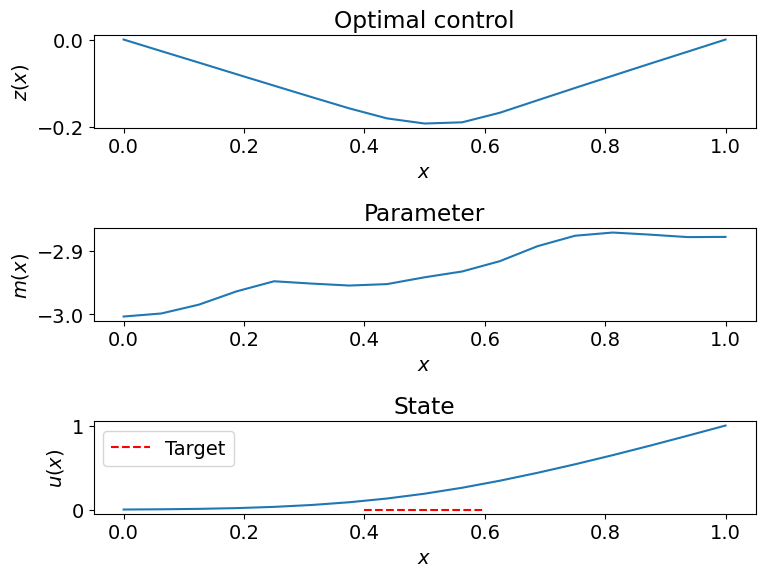

In [41]:

# Initialize vectors for the state, parameter, adjoint (not used) and control variables
x = control_model.generate_vector()

# Initialize the noise vector 
noise = dl.Vector(comm_mesh)
prior.init_vector(noise, "noise")

# Use hippylib's rng to sample Gaussian white noise 
rng = hp.Random(seed=111)

# This is sampling noise with 1.0 standard dev to the noise vector
rng.normal(1.0, noise) 

# The prior then turns the noise into a parameter sample
prior.sample(noise, x[soupy.PARAMETER])

# Also set the CONTROL component of x to the optimal control z
x[soupy.CONTROL].set_local(zt_optimal_np[:-1])

# Solve the forward problem
control_model.solveFwd(x[soupy.STATE], x)

# Convert to functions and plot
u_fun = dl.Function(Vh[soupy.STATE], x[soupy.STATE])
m_fun = dl.Function(Vh[soupy.PARAMETER], x[soupy.PARAMETER])
z_fun = dl.Function(Vh[soupy.CONTROL], x[soupy.CONTROL])

plt.rcParams.update({'font.size': 14})

if comm_sampler.rank == 0:
    plt.figure(figsize=(8,6))
    plt.subplot(311)
    dl.plot(z_fun, title="Optimal control")
    plt.xlabel("$x$")
    plt.ylabel("$z(x)$")
    plt.subplot(312)
    dl.plot(m_fun, title="Parameter")
    plt.xlabel("$x$")
    plt.ylabel("$m(x)$")
    plt.subplot(313)
    dl.plot(u_fun, title="State")
    plt.xlabel("$x$")
    plt.ylabel("$u(x)$")

    x_obs = np.linspace(OBSERVATION_CENTER-OBSERVATION_RADIUS, OBSERVATION_CENTER+OBSERVATION_RADIUS, 10)
    plt.plot(x_obs, np.ones_like(x_obs)*TARGET_VALUE, '--r', label="Target")
    plt.legend()
    plt.tight_layout()

## 9. Comparing this to the expectation as a risk measure
We can also solve the problem using the mean risk measure, as in the previous tutorial

$$ \min_{z} \mathbb{E}[Q] + P(z) $$

We will use the same sample size and random seed. 
For convenience, we will also use the optimal control from the superquantile optimization as the initial guess.

In [42]:
VARIANCE_WEIGHT = 0.0

mean_risk_settings = soupy.meanVarRiskMeasureSAASettings()
mean_risk_settings["beta"] = VARIANCE_WEIGHT
mean_risk_settings["sample_size"] = SAMPLE_SIZE 
mean_risk_settings["seed"] = RANDOM_SEED

mean_risk_measure = soupy.MeanVarRiskMeasureSAA(control_model, prior, mean_risk_settings, comm_sampler=comm_sampler)
mean_cost_functional = soupy.RiskMeasureControlCostFunctional(mean_risk_measure, penalty)

mean_scipy_cost = soupy.ScipyCostWrapper(mean_cost_functional, verbose=False)

# The initial guess as a numpy array 
z_initial_np = zt_optimal_np[:-1]

mean_results = scipy.optimize.minimize(mean_scipy_cost.function(), z_initial_np, method="BFGS",
    jac=mean_scipy_cost.jac(), options=options)
z_optimal_mean_np = mean_results['x']

Optimization terminated successfully.
         Current function value: 0.021642
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


### Distribution of QoIs at optimal controls

We have now solved the OUU problem using two different risk measure
1. Optimal control from superquantile/CVaR, $z_{\mathrm{CVaR}}^{*}$.
2. Optimal control from mean, $z_{\mathrm{Mean}}^{*}$.

We can compare the QoI distributions at the optimal controls. This can be done by solving the PDE at a bunch of samples using either of the two optimal controls.

Here, to see a little more detail about risk measure classes in SOUPy, 
we will instead create a third risk measure using a large sample size and use that to draw the samples of the QoIs. 

The risk measures have two methods that will be useful:
- `computeComponents(z, order)` will compute components (sampling) at `z` required to evaluate the function and its derivatives up to `order`
- `gather_samples` will return the QoI samples computed from `computeComponents`. When running in parallel, this will gather across all MPI processes

We go through and create this evaluation risk measure (either mean + variance or CVaR be fine since we only need the samples). Sampling may take a while.

In [43]:
SAMPLE_SIZE = 2000
RANDOM_SEED = 111

risk_settings_evaluation = soupy.meanVarRiskMeasureSAASettings()
risk_settings_evaluation["sample_size"] = SAMPLE_SIZE 
risk_settings_evaluation["seed"] = RANDOM_SEED
risk_evaluation = soupy.MeanVarRiskMeasureSAA(control_model, prior, risk_settings_evaluation, comm_sampler=comm_sampler)

z = risk_evaluation.generate_vector(soupy.CONTROL)

# For the CVaR result, make sure to exclude last component
z.set_local(zt_optimal_np[:-1])
risk_evaluation.computeComponents(z, order=0)
qoi_samples_cvar = risk_evaluation.gather_samples()

# For the CVaR result, make sure to exclude last component
z.set_local(z_optimal_mean_np[:-1])
risk_evaluation.computeComponents(z, order=0)
qoi_samples_mean = risk_evaluation.gather_samples()


We can now plot these both the optimal controls and their corresponding QoI distributions.

When using the CVaR as the risk measure, we see that the optimal control is a stronger control despite the penalization, since CVaR places greater emphasis on the upper tail of the distribution.

80% CVaR of QoI samples
Using CVaR as risk measure, 0.0110839
Using Mean as risk measure, 0.0132091


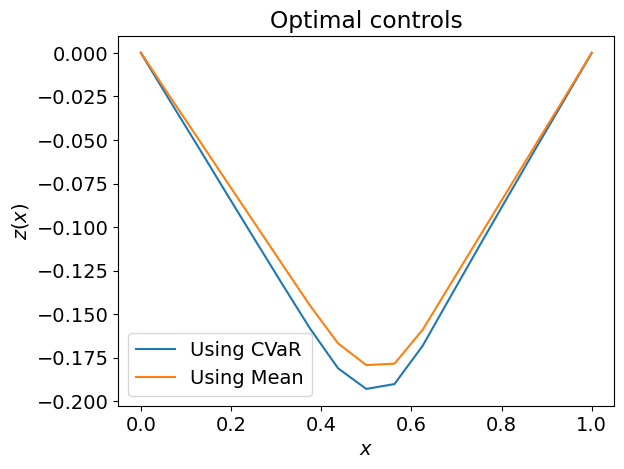

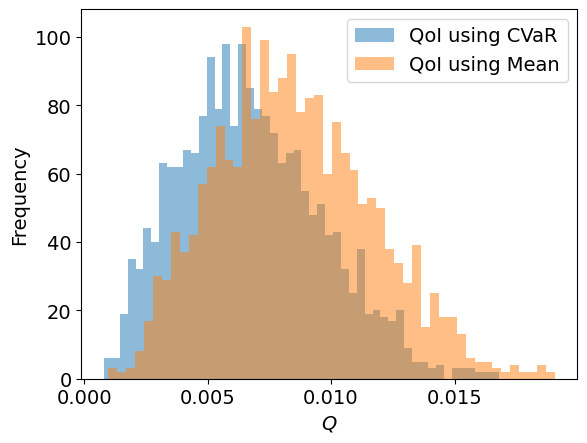

In [44]:
if comm_sampler.rank == 0:
    print("80% CVaR of QoI samples")
    print(f"Using CVaR as risk measure, {soupy.sample_superquantile(qoi_samples_cvar, QUANTILE):g}")
    print(f"Using Mean as risk measure, {soupy.sample_superquantile(qoi_samples_mean, QUANTILE):g}")
    
    plt.figure()
    z_fun.vector().set_local(zt_optimal_np[:-1])
    dl.plot(z_fun, label="Using CVaR")
    z_fun.vector().set_local(z_optimal_mean_np)
    dl.plot(z_fun, label="Using Mean")
    plt.title("Optimal controls")
    plt.xlabel("$x$")
    plt.ylabel("$z(x)$")
    plt.legend()

    plt.figure()
    bar = plt.hist(qoi_samples_cvar, bins=50, label='QoI using CVaR', alpha=0.5)
    bar = plt.hist(qoi_samples_mean, bins=50, label='QoI using Mean', alpha=0.5)
    plt.xlabel("$Q$")
    plt.ylabel("Frequency")
    plt.legend()
plt.show()
